## **Accompanist Tempo Detection**
This notebook is for testing tempo detection methods on recordings and in real-time.

### Currently Implemented Approach
- Load audio signal and remove DC offset
- Set relevant parameters: hop_length = `256 samples`, win_dur = `4 seconds `
- Bandpass filter signal from `[20 Hz, 4 kHz]` to remove noise
- Compute onset envelope using Librosa's onset detection and remove DC offset
- Lowpass filter onset envelope at `10 kHz` and remove any values < `0.05 * max`
- Compute tempogram using Librosa's tempogram function, get tempo bins, and limit to `[35 BPM, 200 BPM]`
- Extract peaks from tempogram to get tempo candidates
- Generate click track for verification

### Pipeline
Load $\to$ Remove DC $\to$ Bandpass $\to$ Onset Envelope $\to$ Lowpass $\to$ Tempogram $\to$ Tempo Estimates

### Approaches For Tempo Detection
1. ✅ Traditional approach of onset detection (STFT + spectral flux) and then compute tempo from the detected onsets. (***Problem:** seems to be quite sensitive to the parameters used*). Maybe try image processing on the tempogram to get tempo? 
<br><br>
Experiment with downsampling:
```python
        sr = 10000
        signal = librosa.resample(signal, orig_sr=sr, target_sr=sr) # downsample to 10 kHz
        t = np.arange(len(signal))/sr
        sf.write(f'../audio_out/{name}_filtered.wav', signal, sr) # save filtered signal
```
2. Some sort of interpolation between tempos to get more accurate estimates? Or use a weighed average of tempos around the peak?
3. Window + lowpass filter each frame of the signal to 20-45 Hz (corresponding to common tempo BPMs) and look at the max frequency component. Maybe do this on the onset envelope if it works better. This is the simplest approach but may not be the most effective. 
4. Similar to decoding an on-off keyed message (i.e. 1 if start of a beat, 0 if not start of a beat). This just involves computing the power of the frequency spectrum of each frame ("bit") and comparing with a threshold. This approach is likely combined with other approaches. 
5. Try wavelet transform instead of stft for onset detection (find power of frequency spectrum of each frame and compute spectral flux). What if each basis function was a wavelet + sin wave?

### Additional Ideas
1. Maybe have the user clap a few times before to establiish a tempo to "calibrate" the alogrithm. Not sure how useful this is in detecting the tempo of the recording, but it helps with syncing at the start.
2. Support different modes:
    - Solo mode: recording always follows the musician. For general practice.
    - Orchestral mode: musicians can set accompanist to match a conductor (timings are determined from a video of the conductor). For orchestral musician practice.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import butter, sosfilt, windows
import os
from math import ceil
import random

In [2]:
#  choose audio file
name = 'chopin_berceuse'
filename = f'{name}.mp3'

In [3]:
# load audio file
audio_path = f'../audio_in/{filename}'
if not os.path.exists(audio_path):
	raise FileNotFoundError(f"Audio file not found: {audio_path}")

signal, sr = librosa.load(audio_path, sr=None)  
signal -= np.mean(signal) # remove DC offset
t = np.arange(len(signal))/sr # get time vector

print(f'Sample rate: {sr}')
print(f'Signal length: {len(signal)}')
print(f'Signal duration: {len(signal)/sr:.3f} s')

Sample rate: 44100
Signal length: 3007424
Signal duration: 68.196 s


Text(0, 0.5, 'Amplitude')

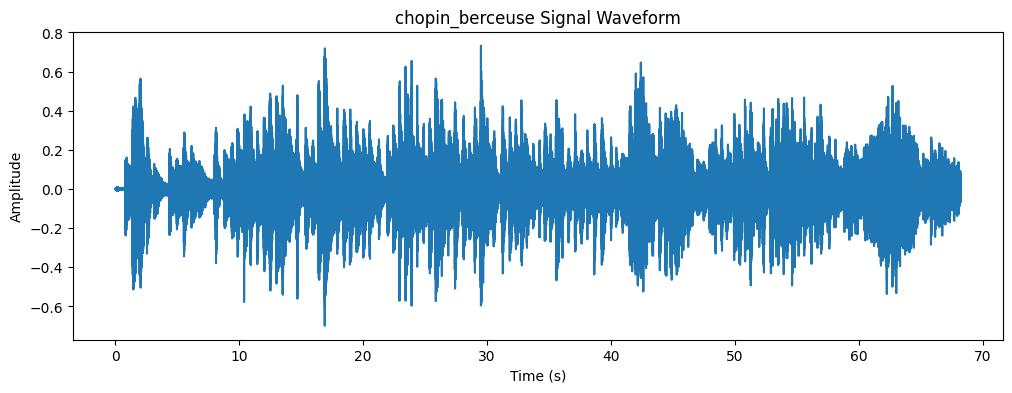

In [4]:
# plot signal waveform
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{name} Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

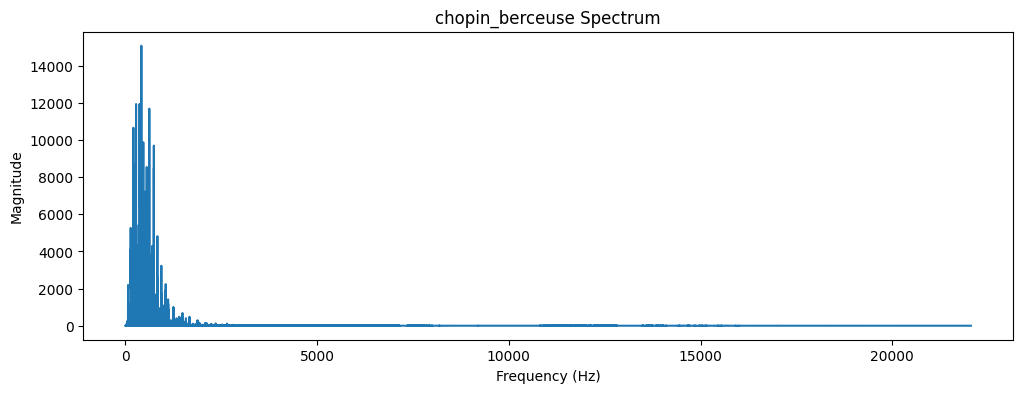

In [5]:
# plot signal spectrum
def plot_spectrum(signal, sr, name, filtered=False):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/sr)
    fft_vals = np.fft.rfft(signal)
    magnitude = np.abs(fft_vals)

    plt.figure(figsize=(12, 4))
    plt.plot(freqs, magnitude)
    if filtered: plt.title(f'{name} Filtered Spectrum')
    else: plt.title(f'{name} Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

plot_spectrum(signal, sr, name)

In [6]:
# bandpass filter
def bandpass_filter(signal, sr, lowcut=60, highcut=4000, order=5):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# lowpass filter
def lowpass_filter(signal, sr, cutoff=4000, order=5):
    sos = butter(order, cutoff, btype='lowpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# highpass filter
def highpass_filter(signal, sr, cutoff=60, order=5):
    sos = butter(order, cutoff, btype='highpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

### 1. Traditional Approach

In [7]:
# define parameters
hop_length = 128 # distance between frames
win_dur = 6 # window duration in seconds

time_res = hop_length/sr # temporal resolution
win_length = int((win_dur*sr)/hop_length) # window length in frames
print(f'Temporal resolution: {time_res:.3f} s')
print(f'Window length: {win_length} frames')

bandpass_high = 4000
bandpass_low = 20
lowpass_cutoff = 10000

tempo_min = 35
tempo_max = 200
alpha = 0.05
plot_tempogram = False

peak_threshold = 0.3

Temporal resolution: 0.003 s
Window length: 2067 frames


In [8]:
# bandpass filter original signal
signal = bandpass_filter(signal, sr, lowcut=bandpass_low, highcut=bandpass_high)
signal /= np.max(np.abs(signal)) # normalize

Text(0, 0.5, 'Amplitude')

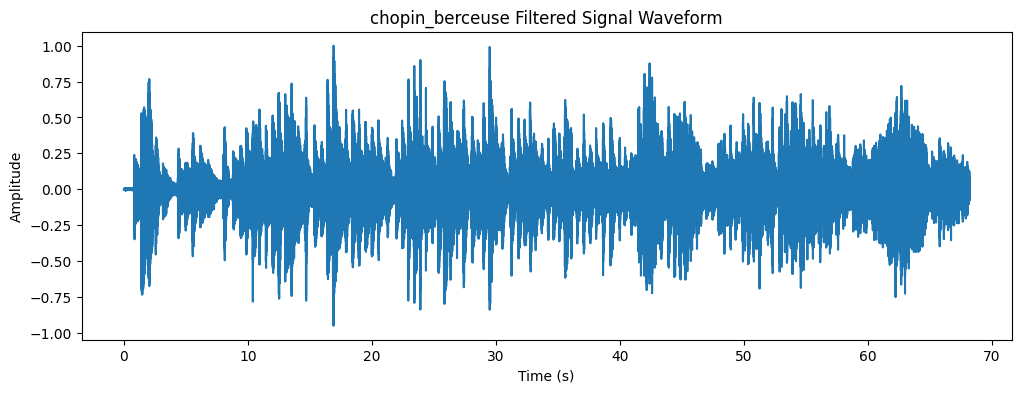

In [9]:
# plot filtered signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{name} Filtered Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

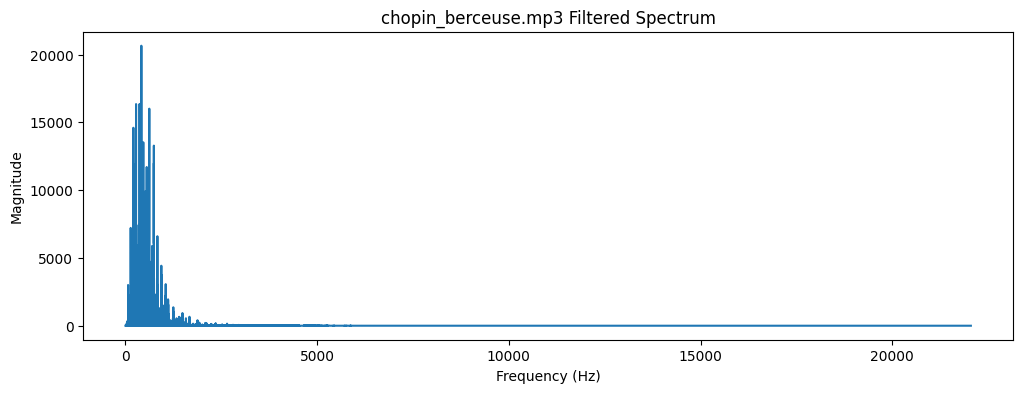

In [10]:
# plot spectrum of filtered signal
plot_spectrum(signal, sr, filename, filtered=True)

In [11]:
# find onset envelope
onset_env = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
onset_env -= np.mean(onset_env)
if np.all(onset_env == 0): 
    raise ValueError('Onset envelope is all zeros. Try a different audio file.')

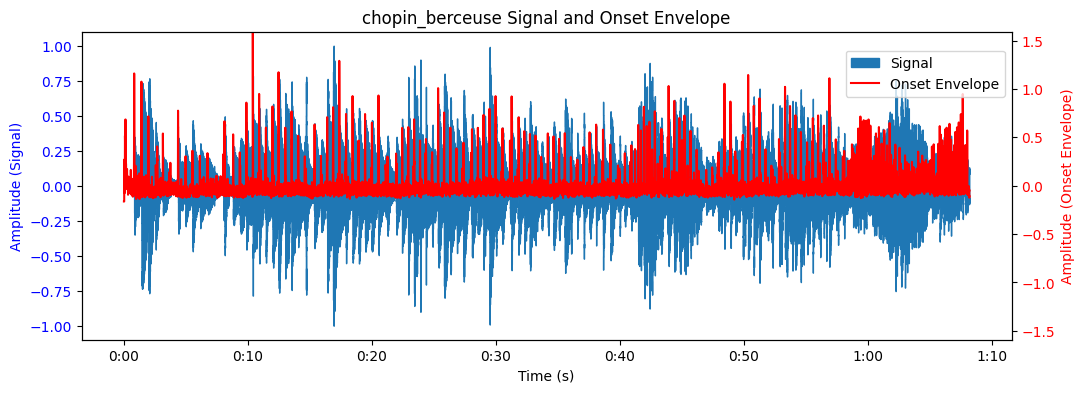

In [12]:
# plot onset envelope overlaid with original signal
fig, ax1 = plt.subplots(figsize=(12, 4))

librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

max_onset = np.max(np.abs(onset_env))
ax2 = ax1.twinx()
ax2.plot(np.arange(len(onset_env))*time_res, onset_env, label='Onset Envelope', color='r')
ax2.set_ylabel('Amplitude (Onset Envelope)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(-max_onset, max_onset)

plt.title(f'{name} Signal and Onset Envelope')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.show()

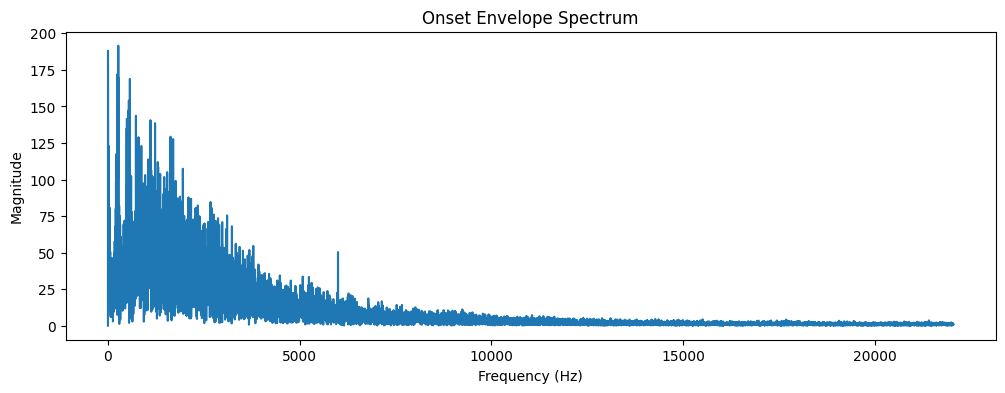

In [13]:
# plot onset envelope spectrum
plot_spectrum(onset_env, sr, 'Onset Envelope')

In [14]:
# filter onset envelope
onset_env = lowpass_filter(onset_env, sr, cutoff=lowpass_cutoff, order=8)

# keep values avove threshold
threshold = alpha * np.max(onset_env)
threshold_idx = np.where(onset_env < threshold)[0]
onset_env[threshold_idx] = 0

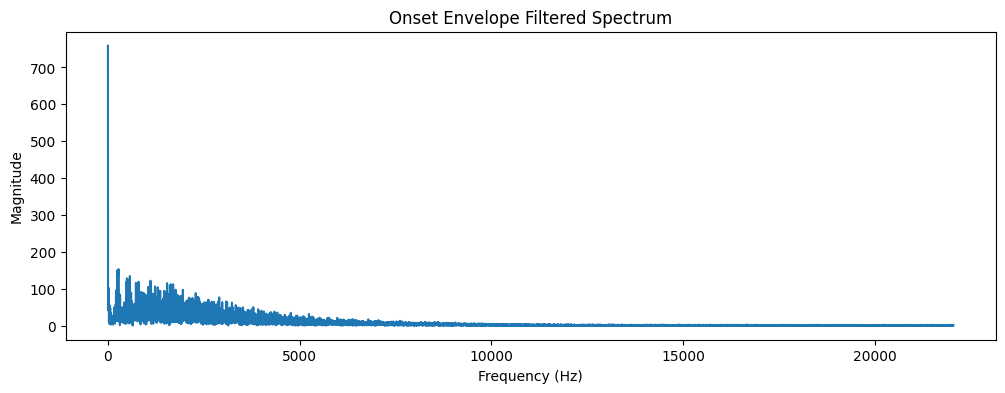

In [15]:
# plot filtered onset envelope spectrum
plot_spectrum(onset_env, sr, 'Onset Envelope', filtered=True)

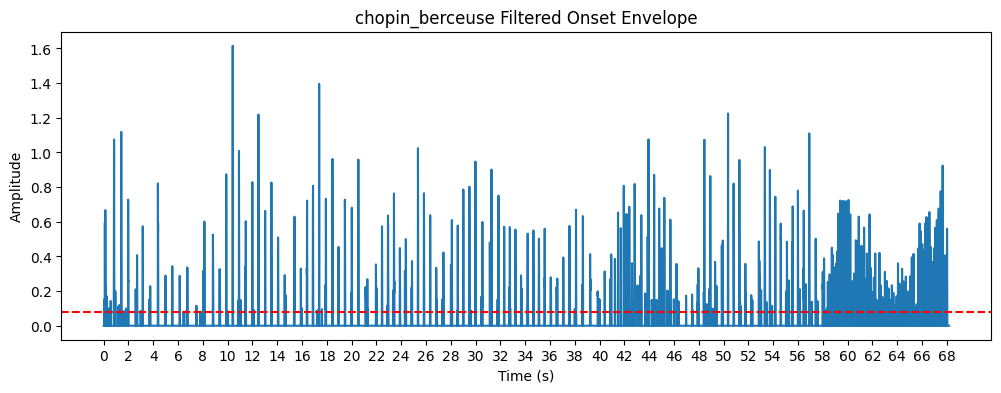

In [16]:
# plot filtered onset envelope
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(onset_env))*time_res, onset_env)
plt.title(f'{name} Filtered Onset Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.axhline(y=threshold, color='r', linestyle='--')
_ = plt.xticks(np.arange(0, len(onset_env)*time_res, 2))

In [17]:
# compute tempogram, skipping first bin
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length, win_length=win_length)[1:,:]
tempo_bins = librosa.tempo_frequencies(tempogram.shape[0], sr=sr, hop_length=hop_length)

# for limiting tempo of tempogram
fmin = max(tempo_min, tempo_bins[-1])
fmax = min(tempo_max, tempo_bins[0])

print(f'Max tempo: {fmax:.2f} BPM')
print(f'Min tempo: {fmin:.2f} BPM')
print(f'Number of tempo bins: {len(tempo_bins)}')

Max tempo: 200.00 BPM
Min tempo: 35.00 BPM
Number of tempo bins: 2066


In [18]:
# plot tempogram
if plot_tempogram:
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', 
                            y_axis='tempo', cmap='inferno')
    plt.ylim(fmin, fmax) 
    plt.colorbar(label='Amplitude')
    plt.title(f'{name} Tempogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Tempo (BPM)')

    yticks = np.arange(ceil(fmin), ceil(fmax), 10)
    _ = plt.yticks(yticks)
    _ = plt.xticks(np.linspace(0, tempogram.shape[1] * time_res, 20))

Using tempo bins from index 104 to index 590
Using tempo bins from 35.04 to 198.77 BPM
Estimated tempos: [103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 103.8787688442211, 1

(35.0, 200.0)

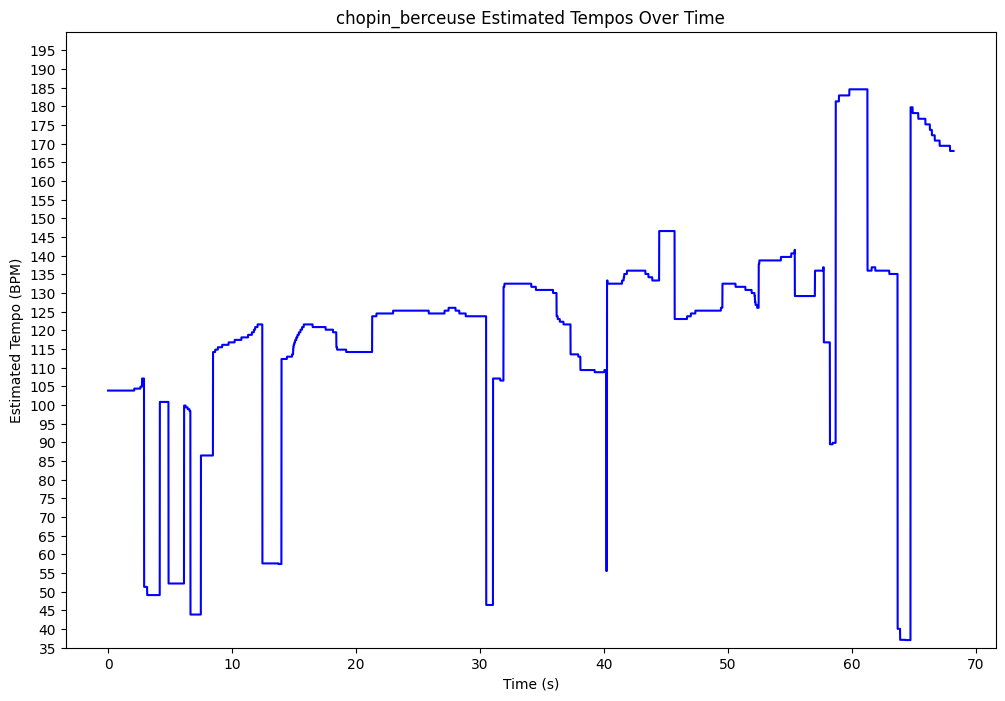

In [19]:
# extract tempos from tempogram
def extract_tempogram_tempos(tempogram, fmin, fmax, peak_threshold=0.3):
    peaks_per_frame = []
    # find indices of fmin and fmax in tempo_bins
    fmin_idx = np.where(tempo_bins >= fmin)[0][-1]
    fmax_idx = np.where(tempo_bins <= fmax)[0][0]
    print(f'Using tempo bins from index {fmax_idx} to index {fmin_idx}')
    print(f'Using tempo bins from {tempo_bins[fmin_idx]:.2f} to {tempo_bins[fmax_idx]:.2f} BPM')

    peaks_per_frame = []
    for i in range(tempogram.shape[1]):
        col = np.abs(tempogram[fmax_idx:fmin_idx, i])
        if np.any(col > 0): peak_idx = np.argmax(col) + fmax_idx
        else: peak_idx = -1
        peaks_per_frame.append(peak_idx)

    estim_tempos = []
    for i, peaks in enumerate(peaks_per_frame):
        if peaks > peak_threshold: estim_tempos.append(float(tempo_bins[peaks]))
        elif i == 0: estim_tempos.append(-1)
        else: estim_tempos.append(estim_tempos[i-1])

    tempo_t = np.arange(len(estim_tempos))*time_res
    print(f'Estimated tempos: {estim_tempos}')
    return estim_tempos, tempo_t

estim_tempos, tempo_t = extract_tempogram_tempos(tempogram, fmin, fmax, peak_threshold=peak_threshold)

# plot estimated tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(tempo_t, estim_tempos, color='b')
plt.title(f'{name} Estimated Tempos Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.ylim(fmin, fmax)

(35.0, 200.0)

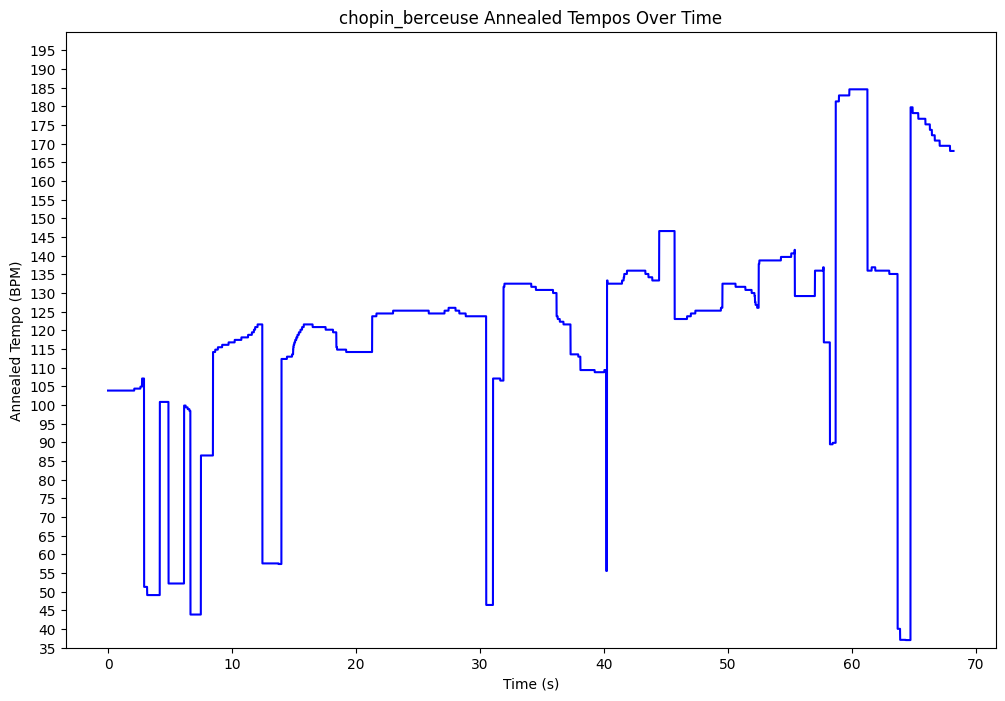

In [ ]:
def anneal_tempos(estim_tempos, p=0.01, max_iter=1000):
    tempos = np.array(estim_tempos, dtype=float)
    orig_range = np.ptp(tempos) # LEFT OFF HERE, FIGURE OUT A BETTER MEASURE OF SPREAD
    for _ in range(max_iter):
        idx = random.randint(0, len(tempos) - 1)
        new_tempos = tempos.copy()
        if random.random() < 0.5: new_tempos[idx] *= 2
        else: new_tempos[idx] /= 2
        new_range = np.ptp(new_tempos)
        if new_range < orig_range or random.random() < p:
            tempos = new_tempos
            orig_range = new_range
    return tempos

estim_tempos = anneal_tempos(estim_tempos, p=0, max_iter=100000)

# plot annealed tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(tempo_t, estim_tempos, color='b')
plt.title(f'{name} Annealed Tempos Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Annealed Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.ylim(fmin, fmax)

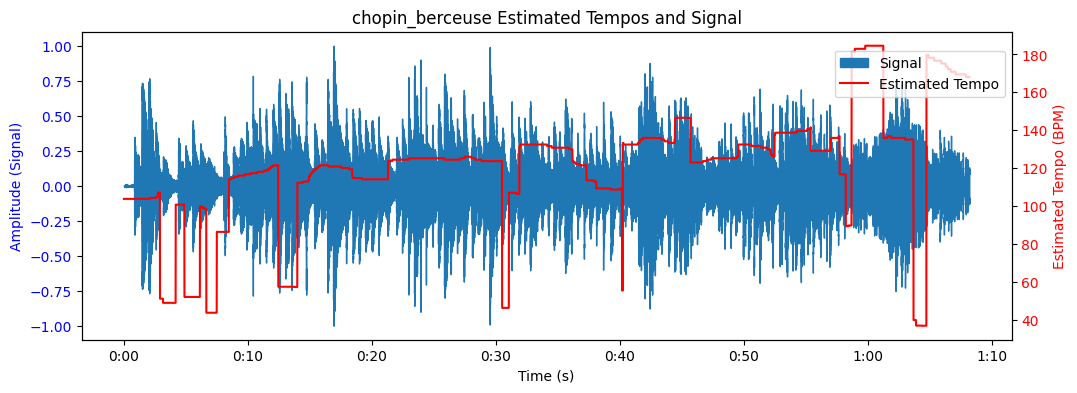

In [21]:
# plot estimated tempos and original signal
fig, ax1 = plt.subplots(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(tempo_t, estim_tempos, color='r', label='Estimated Tempo')
ax2.set_ylabel('Estimated Tempo (BPM)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title(f'{name} Estimated Tempos and Signal')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

In [22]:
# # smooth tempos
# smoothed_tempos = [estim_tempos[0]]
# for i in range(1, len(estim_tempos)):
#     prev = smoothed_tempos[0]
#     candidates = [estim_tempos[i]*(2**k) for k in range(-3, 3)] # generate possible powers of 2 for current tempo
#     candidates = [c for c in candidates if c > fmin and c < fmax]
#     diff = np.abs(np.array([prev]*len(candidates)) - np.array(candidates))
#     best_idx = np.argmin(diff) # choose candidate closest to previous smoothed tempo
#     smoothed_tempos.append(candidates[best_idx])

def apply_fir_filter(signal, window):
    window = np.array(window)
    window /= np.sum(window)
    filtered = np.convolve(signal, window, mode='same')
    return filtered

In [23]:
hamming = windows.hamming(51)
estim_tempos = apply_fir_filter(estim_tempos, hamming)

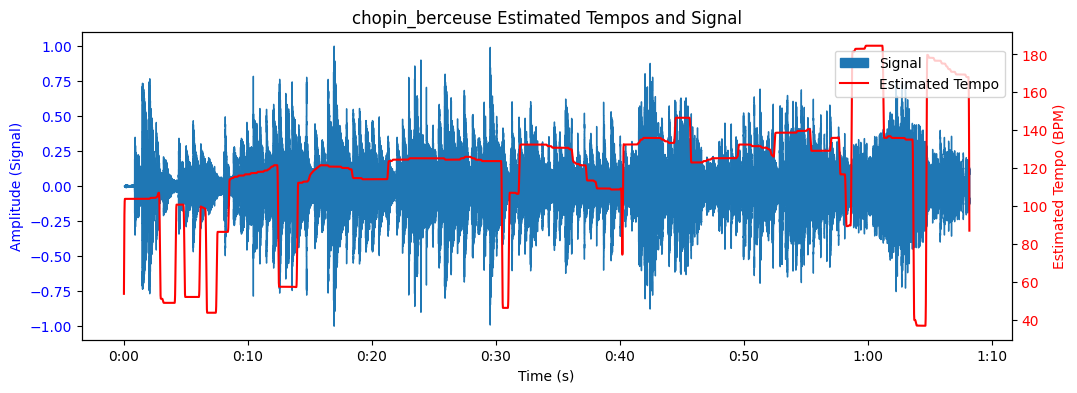

In [24]:
# plot estimated tempos and original signal
fig, ax1 = plt.subplots(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(tempo_t, estim_tempos, color='r', label='Estimated Tempo')
ax2.set_ylabel('Estimated Tempo (BPM)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title(f'{name} Estimated Tempos and Signal')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

In [25]:
# detect start
def detect_start(signal, sr):
    threshold = 0.01 * np.max(np.abs(signal))
    start_idx = 0
    for i, val in enumerate(signal):
        if np.abs(val) > threshold:
            start_idx = i
            break
    return start_idx

# zero pad signal to start at signal
def zero_pad_signal(signal, start_frame):
    return np.concatenate((np.zeros(start_frame), signal))

In [26]:
# generate click track to verify estimated tempos
def generate_click_track_from_estimates(tempo_t, tempos, sr, duration, click_dur=50, click_freq=1000):
    click_track = np.zeros(int(sr*duration))
    click_length = int(click_dur/1000*sr)

    tempos = np.array(tempos)
    tempo_t = np.array(tempo_t)
    change_idxs = np.where(np.diff(tempos) != 0)[0]
    change_idxs = np.concatenate(([0], change_idxs+1, [len(tempos)])) # always include the first index

    # start at the first time
    current_time = tempo_t[0] if len(tempo_t) > 0 else 0.0

    for seg_idx in range(len(change_idxs)-1):
        seg_start = change_idxs[seg_idx]
        seg_end = change_idxs[seg_idx+1]
        tempo = tempos[seg_start]
        if tempo <= 0:
            # skip this segment, but advance current_time to the start of next segment
            if seg_end < len(tempo_t):
                current_time = tempo_t[seg_end]
            continue
        t_start = tempo_t[seg_start]
        t_end = tempo_t[seg_end-1] if seg_end < len(tempo_t) else duration
        T = 60.0/tempo
        current_time = max(current_time, t_start) # always start placing clicks at the start of the segment
        while current_time < t_end:
            idx = int(current_time*sr)
            if idx + click_length <= len(click_track):
                click_track[idx:idx+click_length] += 0.5
            elif idx < len(click_track):
                click_track[idx:] += 0.5
            current_time += T # at the end of the segment, current_time is carried over to the next segment

    # modulate click track with sine wave
    sin_wave = np.sin(2*np.pi*click_freq*np.arange(len(click_track))/sr)
    click_track *= sin_wave

    # plot click track
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(click_track))/sr, click_track)
    plt.title('Click Timings')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    return click_track

Click track saved to: ../audio_out/click_chopin_berceuse.mp3


Text(0, 0.5, 'Amplitude')

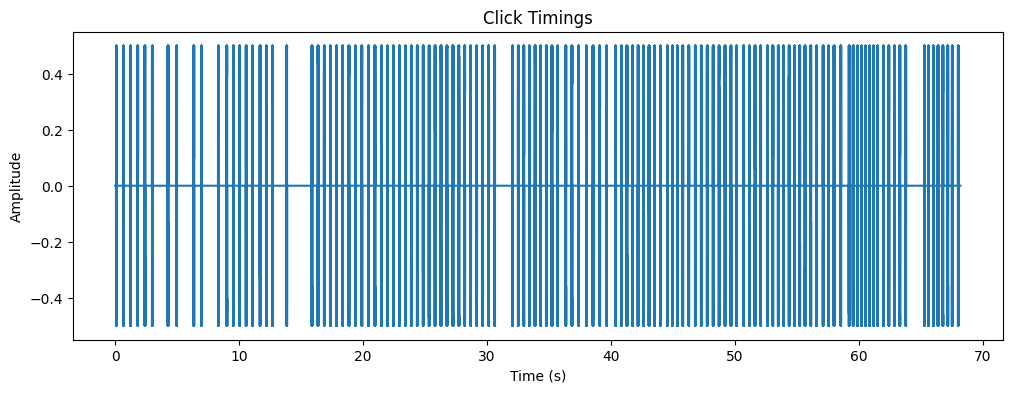

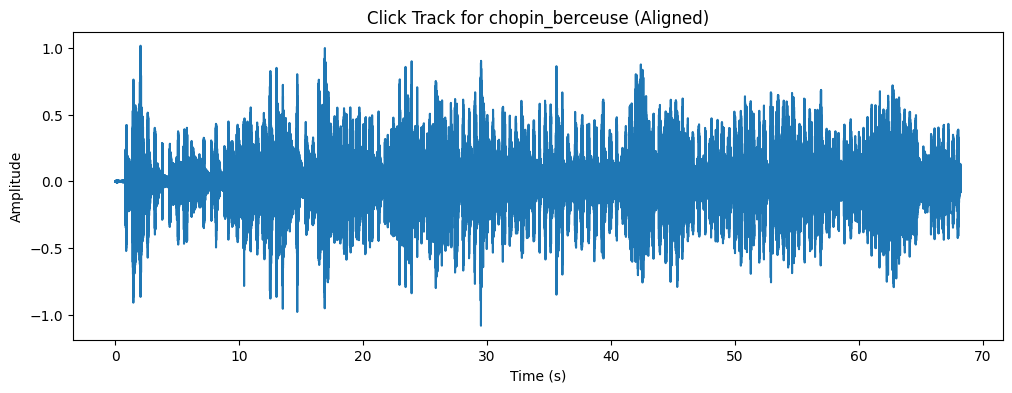

In [27]:
# align click track with first note
start_frame = detect_start(signal, sr)
duration = len(signal)/sr
click_track = generate_click_track_from_estimates(tempo_t, estim_tempos, sr, duration)
click_track_aligned = zero_pad_signal(click_track, start_frame)

combined = signal + 0.5 * click_track_aligned[:len(signal)]

# save click track to file
click_track_path = f'../audio_out/click_{name}.mp3'
sf.write(click_track_path, combined, sr)
print(f'Click track saved to: {click_track_path}')

# plot click track
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(combined))/sr, combined)
plt.title(f'Click Track for {name} (Aligned)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')